In [1]:
from IPython.display import clear_output as cls

In [2]:
# data no split
# https://drive.google.com/file/d/1ey1O_1cZEnqP8s4mHjCvT8vpfAOlvP9L/view?usp=sharing

# data with split - train val test
# https://drive.google.com/file/d/14Rjq65k_qzXDje0atzyDl9WziapGaifp/view?usp=sharing

# data with split and converted - train val test
# https://drive.google.com/file/d/10eYtkh6bTWNwH_--xZtU8IxB5cZPVc3O/view?usp=drive_link

# data with split and converted clean - train val test
# https://drive.google.com/file/d/184s1XY7oZ2ukeMUzhMjH-MEXROGuGCk3/view?usp=drive_link
!pip install gdown

!rm -r dataset
!gdown "https://drive.google.com/uc?id=184s1XY7oZ2ukeMUzhMjH-MEXROGuGCk3" -O dataset.zip
!unzip dataset.zip -d dataset

cls()

In [3]:
# common
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from tqdm import tqdm
from glob import glob

# preprocessing
from tensorflow import image as tfi

# architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# output cell
from IPython.display import clear_output as cls

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
train_dir = '/kaggle/working/dataset/clean_data_splitted_convert/train/'
val_dir = '/kaggle/working/dataset/clean_data_splitted_convert/val/'
test_dir = '/kaggle/working/dataset/clean_data_splitted_convert/test/'

In [5]:
# Constants

IMAGE_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 10

LEARNING_RATE = 2e-5

LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = ['accuracy']

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

## Data Loading

In [6]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Show
print(f"Total number of classes in train: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes in train: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


### Check Corrupt Data

In [7]:
def load_image(image_path: str) -> tf.Tensor:
    
    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some 
    preprocessing steps such as resizing and normalization.
    
    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.
        
    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''
    
    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'
    
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Load the image
    try:
        image = tfi.decode_jpeg(image, channels=3)
    except:
        image = tfi.decode_png(image, channels=3)
    
    # Change the image data type
    image = tfi.convert_image_dtype(image, tf.float32)
    
    # Resize the Image
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image

In [8]:
def load_dataset(root_path: str, class_names: list, batch_size: int = 32, buffer_size: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        batch_size (int): Batch size of the final dataset. Defaults to 32.
        buffer_size (int): Buffer size to use when shuffling the data. Defaults to 1000.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''

    # Collect total number of data samples
    n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    errors = []
    
    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        for file_path in glob(os.path.join(class_path, "*")):
            # Load the image
            try:
                image = load_image(file_path)
                
                # Assign label
                label = class_names.index(class_name)

                # Store the image and the respective label
                images[n_image] = image
                labels[n_image] = label

                # Increment the number of images processed
                n_image += 1
                
            except:
                errors.append(file_path)
            
    # Shuffle the data
    indices = np.random.permutation(n_samples)
    images = images[indices]
    labels = labels[indices]
    
    print('num of errors:', len(errors))

    return images, labels, errors

In [9]:
# # Load the training dataset
# X_train, y_train, err_train = load_dataset(root_path = train_dir, class_names = class_names)

# # # Load the validation dataset
# X_valid, y_valid, err_val = load_dataset(root_path = val_dir, class_names = class_names)

# # Load the testing dataset
# X_test, y_test, err_test = load_dataset(root_path = test_dir, class_names = class_names)

In [10]:
# print('train err:', err_train)
# print('val err:', err_val)
# print('test err:', err_test)

In [11]:
# del X_train, y_train, X_valid, y_valid, X_test, y_test

### Drop corrupted data

In [12]:
corrupted = '/kaggle/working/dataset/clean_data_splitted_convert/train/ra/000021.jpg'
os.remove(corrupted)

### Augmentasi

In [13]:
pass

### Input Preprocessing Pipeline

- Rescaling
- Standardization

In [14]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

### Load with Tensor Datasets

In [15]:
# del train_ds, val_ds, test_ds
# del train_ds_mapped, val_ds_mapped, test_ds_mapped

# Create a dataset from the data directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
#                                                                labels='inferred', 
#                                                                label_mode='int',
#                                                                image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size=BATCH_SIZE
                                                              )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
#                                                              labels='inferred', 
#                                                              label_mode='int',
#                                                              image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE
                                                              )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
#                                                               labels='inferred', 
#                                                               label_mode='int',
#                                                               image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size=BATCH_SIZE
                                                              )

Found 3404 files belonging to 20 classes.
Found 207 files belonging to 20 classes.
Found 202 files belonging to 20 classes.


### preprocessing

In [16]:
train_ds_mapped = train_ds.map(load_and_preprocess_image)
val_ds_mapped = val_ds.map(load_and_preprocess_image)
test_ds_mapped = test_ds.map(load_and_preprocess_image)

### Data Distribution

In [17]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(val_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(test_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

### Data Visualization

In [18]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 1.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (10, 10).
    """
    
    for images, labels in dataset.take(1):
#     images, labels = next(iter(dataset))
    
        # Create a figure to display the images
        fig = plt.figure(figsize=figsize)

        # Loop over the number of rows and columns
        for i in range(n_rows * n_cols):

            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis])

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, i+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Show the plot
    plt.show()

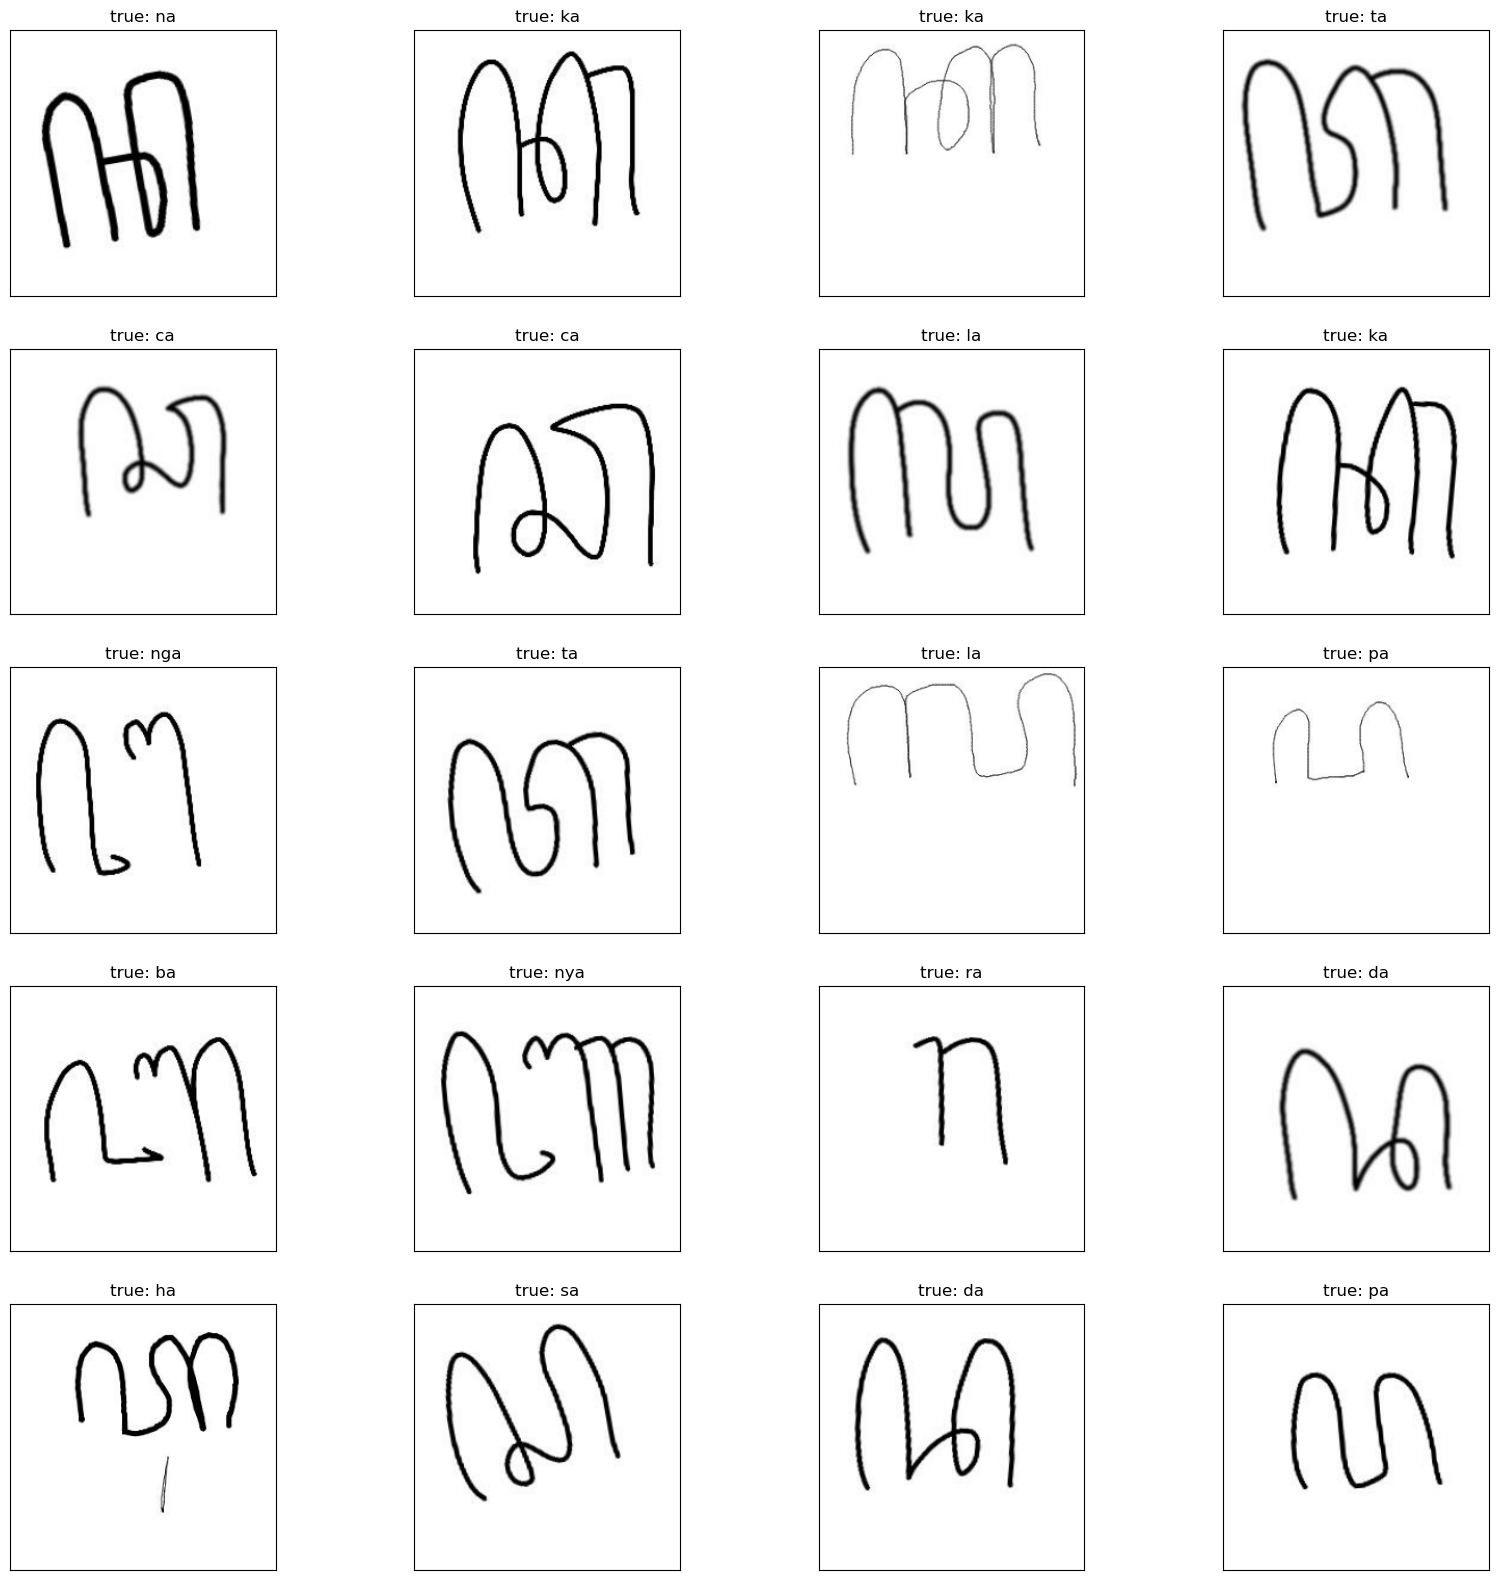

In [19]:
plot_images(train_ds)

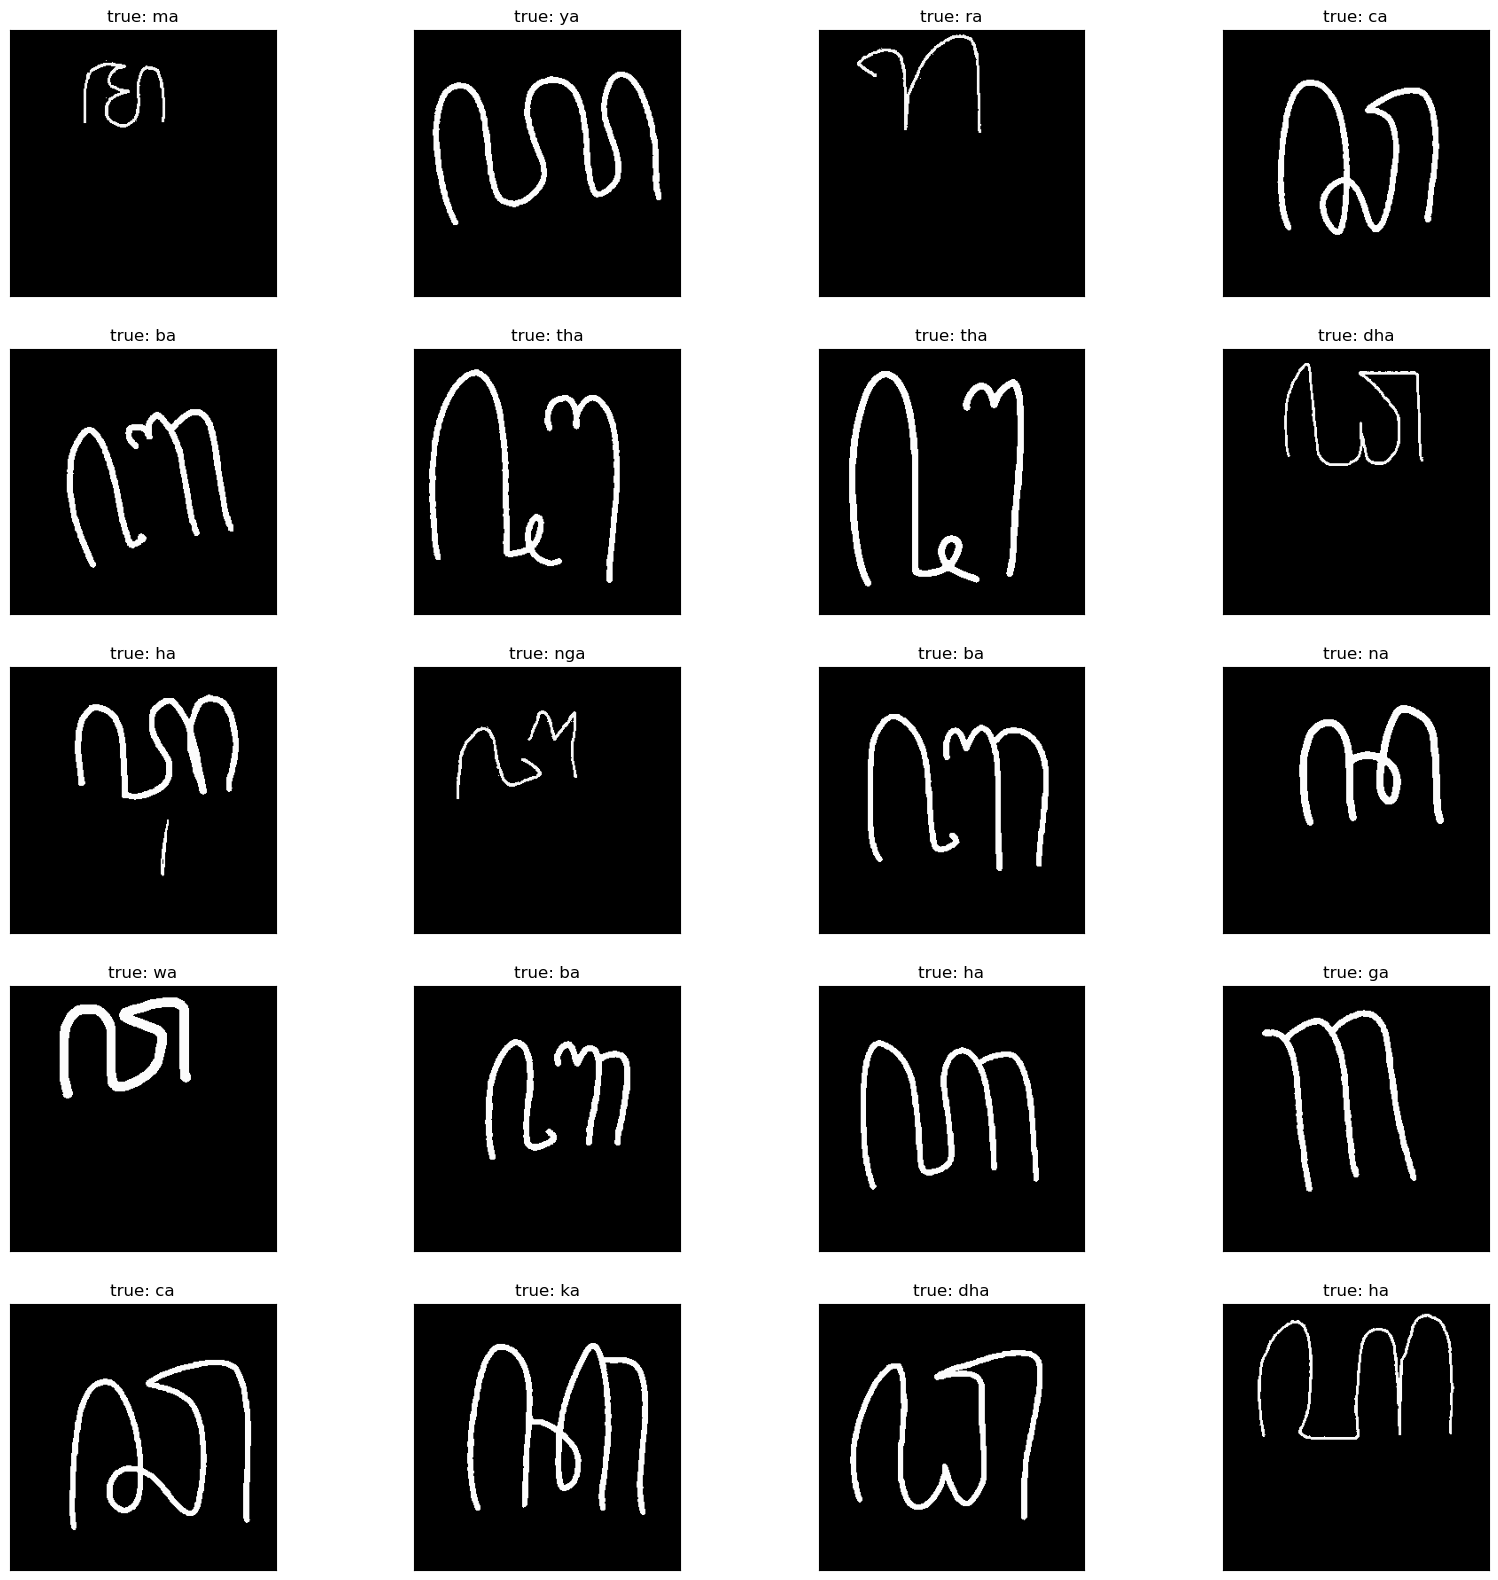

In [20]:
plot_images(train_ds_mapped)

## Train and Fine Tuning

#### No Freeze

In [21]:
# Xception

xception = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

# xception.trainable = False
xception.trainable = True

83683744/83683744 [==============================] - 0s 0us/step


In [22]:
# num_layers = len(xception.layers) // 2
# num_layers

# for i in range(num_layers):
#     xception.layers[i].trainable = False

In [23]:
name = 'aksara_jawa_xception_no_freeze_v1'

xception_transferred = Sequential([
    xception,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name=name)

xception_transferred.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

xception_transferred.summary()

Model: "aksara_jawa_xception_no_freeze_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 20,902,460
Trainable params: 20,847,932
Non-trainable params: 54,528
_________________________________________________________________


In [24]:
# Print the trainable status of each layer
for layer in xception_transferred.layers:
    print(f'{layer.name}: {layer.trainable}')

xception: True
global_average_pooling2d: True
dropout: True
dense: True


In [25]:
# plot_model(
#     xception_transferred,
#     to_file='xception_transferred.png',
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
# #     expand_nested=True,
#     dpi=96,
#     show_layer_activations=True
# )

In [26]:
print("\nTraining Xception Model: ")

# steps_per_epoch = len(X_train)
# STEPS_PER_EPOCH = 50

history = xception_transferred.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(f"{name}.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH
)


Training Xception Model: 
Epoch 1/10
107/107 [==============================] - 97s 534ms/step - loss: 2.6676 - accuracy: 0.2806 - val_loss: 2.4641 - val_accuracy: 0.4155
Epoch 2/10
107/107 [==============================] - 53s 496ms/step - loss: 1.5107 - accuracy: 0.7406 - val_loss: 0.9791 - val_accuracy: 0.7585
Epoch 3/10
107/107 [==============================] - 53s 496ms/step - loss: 0.7383 - accuracy: 0.8872 - val_loss: 0.3764 - val_accuracy: 0.8986
Epoch 4/10
107/107 [==============================] - 53s 496ms/step - loss: 0.3412 - accuracy: 0.9559 - val_loss: 0.1973 - val_accuracy: 0.9469
Epoch 5/10
107/107 [==============================] - 53s 495ms/step - loss: 0.1738 - accuracy: 0.9821 - val_loss: 0.1442 - val_accuracy: 0.9565
Epoch 6/10
107/107 [==============================] - 53s 496ms/step - loss: 0.0978 - accuracy: 0.9915 - val_loss: 0.0923 - val_accuracy: 0.9855
Epoch 7/10
107/107 [==============================] - 54s 497ms/step - loss: 0.0627 - accuracy: 0.9944 

## Evaluate

In [27]:
test_loss, test_acc = xception_transferred.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

7/7 [==============================] - 2s 224ms/step - loss: 0.0511 - accuracy: 0.9851
Loss    : 0.05106
Accuracy: 98.51%


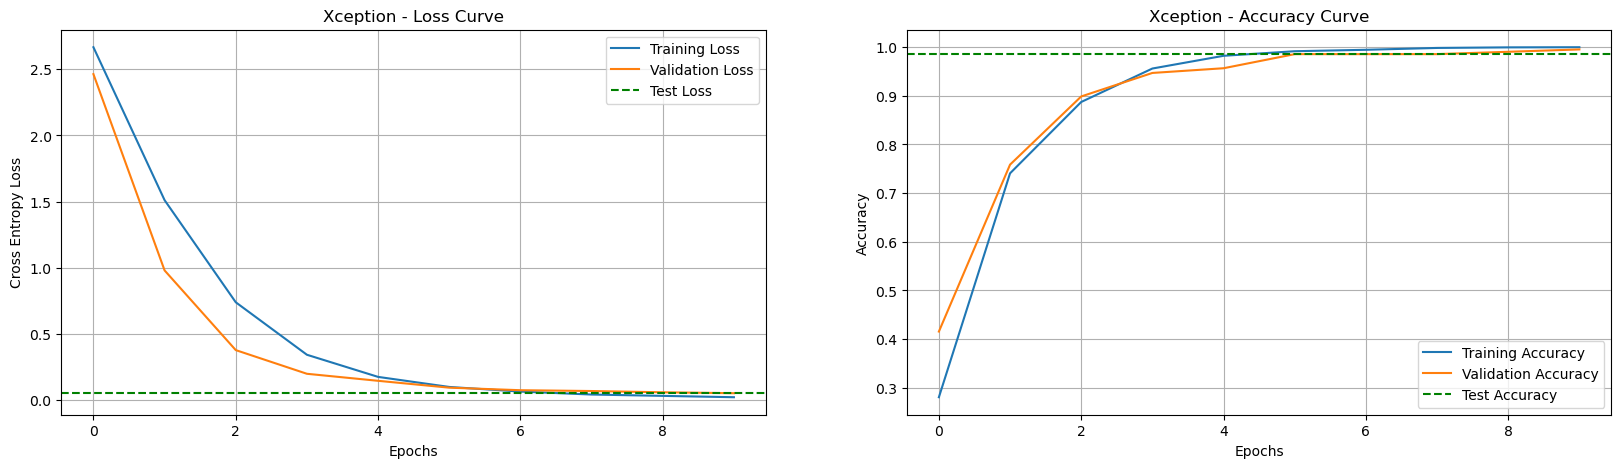

In [28]:
# Collect the history of the training run
history_plot = pd.DataFrame(history.history)

# Create a figure to display the model's performance
plt.figure(figsize=(20, 5))

# Plot the loss curve in the first subplot
plt.subplot(1, 2, 1)
plt.title("Xception - Loss Curve")
plt.plot(history_plot['loss'], label="Training Loss")
plt.plot(history_plot['val_loss'], label="Validation Loss")

# Horizontal line to show the testing performance
plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
# plt.ylim([0, 0.4])

# Show the legend and grid
plt.legend()
plt.grid()

# Plot the accuracy curve in the second subplot
plt.subplot(1, 2, 2)
plt.title("Xception - Accuracy Curve")
plt.plot(history_plot['accuracy'], label="Training Accuracy")
plt.plot(history_plot['val_accuracy'], label="Validation Accuracy")

# Horizontal line to show the testing performance
plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim([0.85, 1])

# Show the legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()

## Output Prediction

1/1 [==============================] - 0s 22ms/step


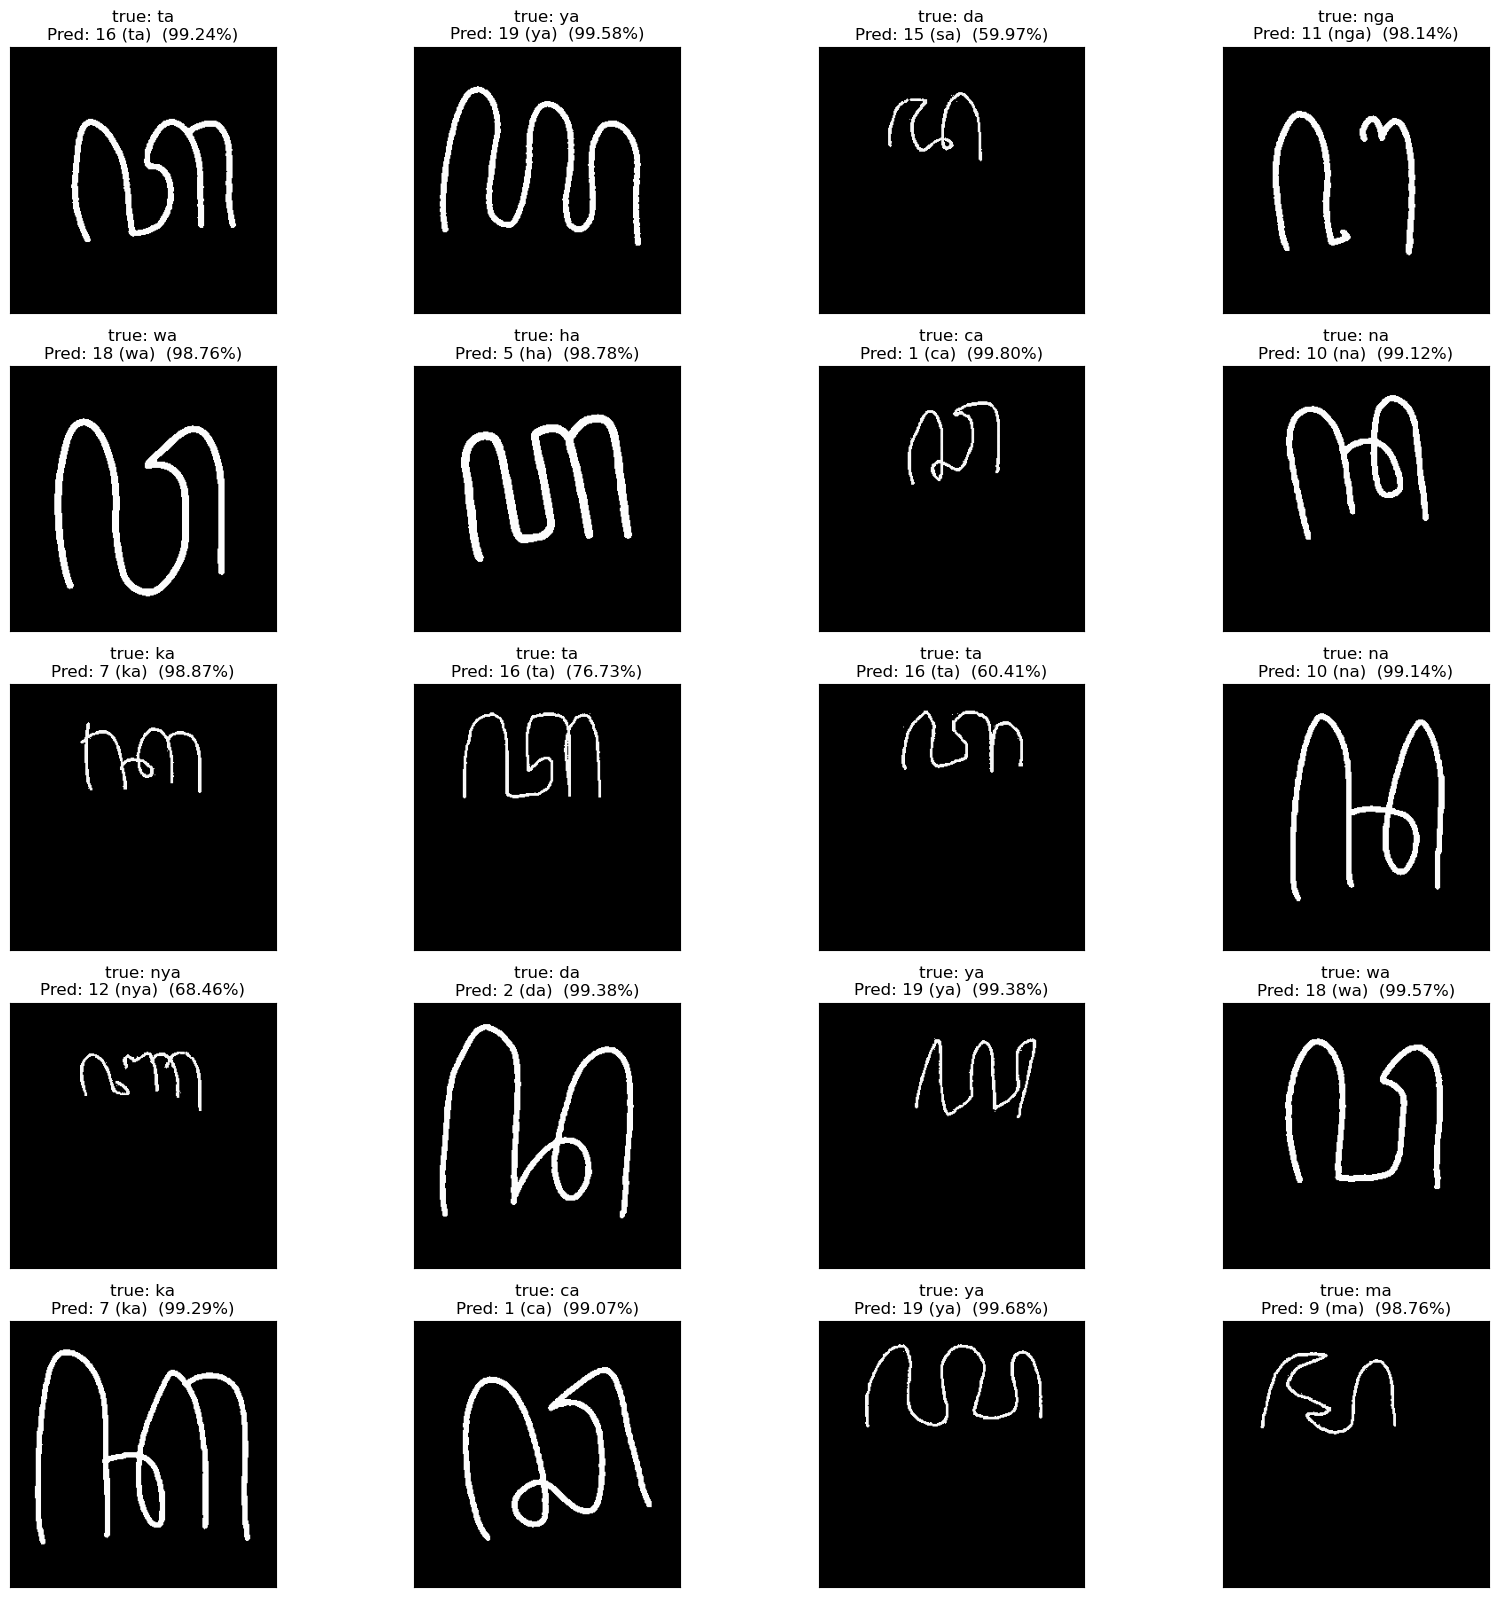

In [30]:
plot_images(test_ds_mapped, model=xception_transferred, n_rows=5)

1/1 [==============================] - 0s 23ms/step


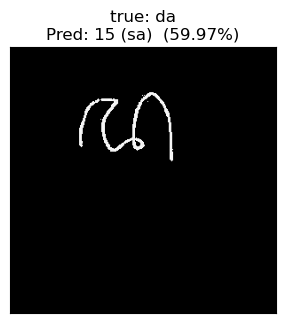

In [34]:
plot_images(test_ds_mapped, model=xception_transferred, n_rows=5, check=True)

1/1 [==============================] - 0s 22ms/step


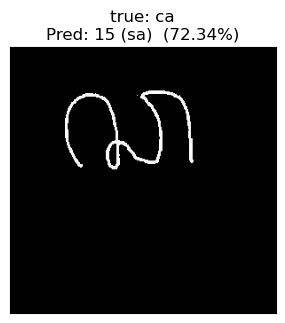

In [37]:
plot_images(test_ds_mapped, model=xception_transferred, n_rows=5, check=True)

1/1 [==============================] - 0s 26ms/step


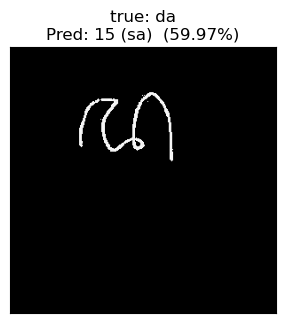

In [43]:
plot_images(test_ds_mapped, model=xception_transferred, n_rows=5, check=True)